## Imports...

In [7]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math 
from collections import defaultdict

### First load all of the static image gestures. These are gestures that have no movement.

In [32]:
gesture_path = './gestures'
# If you recieve nothing from these lines make sure you have run nthe data_in scripts.
gesture_files = glob.glob("./gestures/*.csv")

def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text


def remove_suffix(text, suffix):
    if text.endswith(suffix):
        return text[: -1 * len(suffix)]
    return text


static_gestures = {}
# iterate through all of the gestures... Static pose is finding the median point of the dataframe.
for indx, gesture_file in enumerate(gesture_files):
  
  df = pd.read_csv(gesture_file)
  
  gesture_file = remove_prefix(gesture_file, './gestures/')
  gesture_file = remove_suffix(gesture_file, '.csv')
  
  file_parts = gesture_file.split('_')
  gesture_name = file_parts[0]
  gesture_part = f"{file_parts[2]}"

  if df.empty:
      continue
  
  # convert string to time.
  df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S.%f').dt.time
  
  sdf = np.sort(df['time'].to_numpy(), axis=0)
  # Get the lower level bound median
  ts_median = sdf[math.floor(len(sdf) / 2 )]
  
  # Get the static point image/gesture...
  ndf = df[df['time'].isin([ts_median])]
  newGestureData = static_gestures.get(gesture_name, {})
  newGestureData[gesture_part] = ndf
  static_gestures[gesture_name] = newGestureData
  
print(static_gestures['ONE'])

./gestures/BORN_Transcription_Right_Hand.csv
BORN_Transcription_Right_Hand
['BORN', 'Transcription', 'Right', 'Hand'] BORN_Transcription_Right_Hand
BORN Right
./gestures/HEADWEAR_Transcription_Left_Hand.csv
HEADWEAR_Transcription_Left_Hand
['HEADWEAR', 'Transcription', 'Left', 'Hand'] HEADWEAR_Transcription_Left_Hand
HEADWEAR Left
./gestures/FLU_Transcription_Pose.csv
FLU_Transcription_Pose
['FLU', 'Transcription', 'Pose'] FLU_Transcription_Pose
FLU Pose
./gestures/COUSIN_Transcription_Right_Hand.csv
COUSIN_Transcription_Right_Hand
['COUSIN', 'Transcription', 'Right', 'Hand'] COUSIN_Transcription_Right_Hand
COUSIN Right
./gestures/CITIES_Transcription_Right_Hand.csv
CITIES_Transcription_Right_Hand
['CITIES', 'Transcription', 'Right', 'Hand'] CITIES_Transcription_Right_Hand
CITIES Right
./gestures/CLAM_Transcription_Right_Hand.csv
CLAM_Transcription_Right_Hand
['CLAM', 'Transcription', 'Right', 'Hand'] CLAM_Transcription_Right_Hand
CLAM Right
./gestures/OFFSPRING_Transcription_Right_Han

[]
./gestures/ONE_Transcription_Right_Hand.csv
                time  index     x_angle     y_angle     z_angle         x   
294  00:00:01.688680      0  271.192450   15.598452  344.398334  0.403693  \
295  00:00:01.688680      1  270.869724  357.139850    2.860479  0.406804   
296  00:00:01.688680      2  272.342187  335.898667   24.119187  0.421466   
297  00:00:01.688680      3  306.051445  276.284902   84.911667  0.437492   
298  00:00:01.688680      4  151.389875   35.169639  235.801026  0.426261   
299  00:00:01.688680      5  268.715344  354.268720    5.732711  0.433654   
300  00:00:01.688680      6  271.313138  352.537675    7.464263  0.438843   
301  00:00:01.688680      7  270.283118  352.529435    7.470655  0.442957   
302  00:00:01.688680      8   90.019101  357.769841  177.769841  0.449103   
303  00:00:01.688680      9  268.326827    0.550576  359.449189  0.448639   
304  00:00:01.688680     10   73.137885   29.218353  210.303242  0.439647   
305  00:00:01.688680     11  

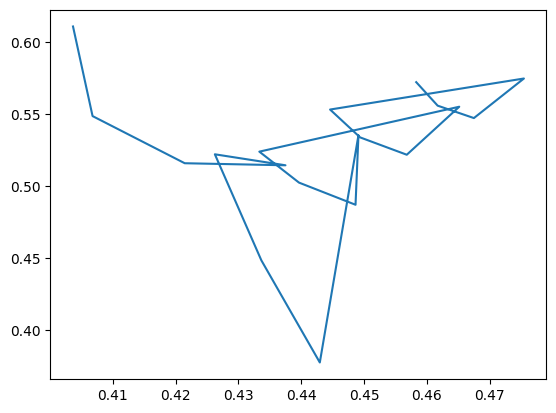

In [38]:
# Loop through a list of images, compare the output with the alg. Compare the output to what is defined.
# How do we handle not still images? Do we train on not still images? Classification


mypath = './gestures'

print(glob.glob("./gestures/ONE.csv"))
gesture_files = glob.glob("./gestures/ONE*.csv")

# start at the first five.. TODO: remove
for indx, gesture_file in enumerate(gesture_files):
  
  print(gesture_file)
  
  df = pd.read_csv(gesture_file)
  
  # Parse the time from string.
  df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S.%f').dt.time
  
  sdf = np.sort(df['time'].to_numpy(), axis=0)
  # Get the lower level bound median
  ts_median = sdf[math.floor(len(sdf) / 2 )]
  
  # Get the static point image/gesture...
  ndf = df[df['time'].isin([ts_median])]
  print(ndf)
  plt.plot(ndf['x'], ndf['y'])
  # print(df.columns)